# Detection of Rice Varieties

## Problem Statement
- Classify rice varieties using ANN, DNN and CNN models.


## Description:

> **Dataset :** https://www.muratkoklu.com/datasets/

- Rice, which is among the most widely produced grain products worldwide, has many genetic varieties. These varieties are separated from each other due to some of their features. These are usually features such as texture, shape, and color. 

- With these features that distinguish rice varieties, it is possible to classify and evaluate the quality of seeds. 

- In this study, `Arborio`, `Basmati`, `Ipsala`, `Jasmine` and `Karacadag`, which are five different varieties of rice often grown in Turkey, are used. 

- A total of 75,000 grain images, 15,000 from each of these varieties, are included in the dataset. 


## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
# importing Open CV library
import cv2
import random
import os
from os import listdir
from PIL import Image

import tensorflow as  tf
from tensorflow import keras
from keras import layers
from keras.layers import Input, Lambda
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model  
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from tensorflow.keras import optimizers, losses
import seaborn as sns
from keras.models import Sequential
from glob import glob
from skimage import io
from tensorflow import io

from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.models import model_from_json
from keras.utils import to_categorical 

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# For ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Visualising the Dataset

### Number of Classes

In [3]:
# glob function is useful for getting number of classes
dataset_folder = glob(r"C:\Users\vilas\Rice_Image_Dataset\*")
print("Number of Classes are:", len(dataset_folder))

Number of Classes are: 5


### Path of all the classes' folders

In [4]:
dataset_folder

['C:\\Users\\vilas\\Rice_Image_Dataset\\Arborio',
 'C:\\Users\\vilas\\Rice_Image_Dataset\\Basmati',
 'C:\\Users\\vilas\\Rice_Image_Dataset\\Ipsala',
 'C:\\Users\\vilas\\Rice_Image_Dataset\\Jasmine',
 'C:\\Users\\vilas\\Rice_Image_Dataset\\Karacadag']

### Finding out Number of Images in each Class

In [5]:
number_classes = {'Arborio': len(os.listdir('C:\\Users\\vilas\\Rice_Image_Dataset\\Arborio')),
'Basmati': len(os.listdir('C:\\Users\\vilas\\Rice_Image_Dataset\\Basmati')),
'Ipsala': len(os.listdir('C:\\Users\\vilas\\Rice_Image_Dataset\\Ipsala')),
'Jasmine': len(os.listdir('C:\\Users\\vilas\\Rice_Image_Dataset\\Jasmine')),
'Karacadag': len(os.listdir('C:\\Users\\vilas\\Rice_Image_Dataset\\Karacadag'))}

number_classes_df= pd.DataFrame(data= number_classes.values(), index=number_classes.keys(), columns=['Number of Images'])
number_classes_df

,Number of Images
Arborio,15000
Basmati,15000
Ipsala,15000
Jasmine,15000
Karacadag,15000


### Plotting Image Size

In [6]:
directories = {'Arborio': 'C:\\Users\\vilas\\Rice_Image_Dataset\\Arborio\\',
'Basmati': 'C:\\Users\\vilas\\Rice_Image_Dataset\\Basmati\\',
'Ipsala': 'C:\\Users\\vilas\\Rice_Image_Dataset\\Ipsala\\',
'Jasmine': 'C:\\Users\\vilas\\Rice_Image_Dataset\\Jasmine\\',
'Karacadag': 'C:\\Users\\vilas\\Rice_Image_Dataset\\Karacadag\\'}

def get_dims(file):
    '''Returns dimenstions for an RBG image'''
    im = Image.open(file)
    arr = np.array(im)
    h,w,d = arr.shape

    return h,w

In [7]:
import dask.bag as db
import dask
from dask.diagnostics import ProgressBar

[########################################] | 100% Completed | 2.89 ss
[########################################] | 100% Completed | 2.88 ss
[########################################] | 100% Completed | 2.87 ss
[########################################] | 100% Completed | 2.75 ss
[########################################] | 100% Completed | 3.13 ss


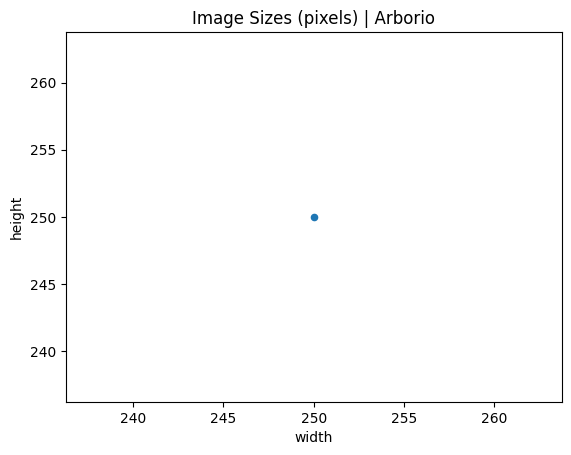

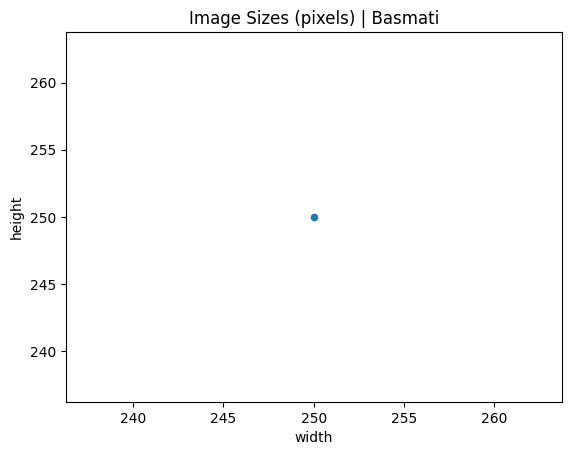

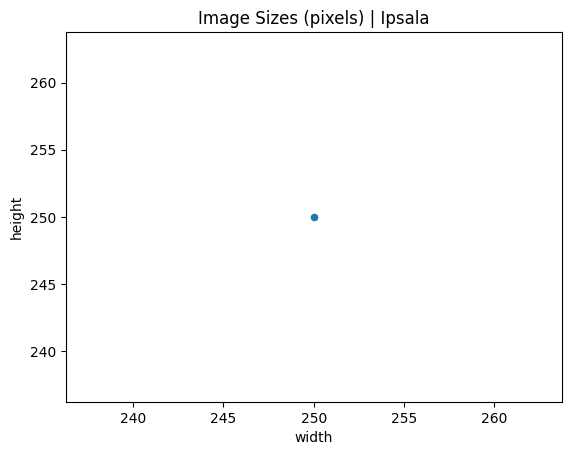

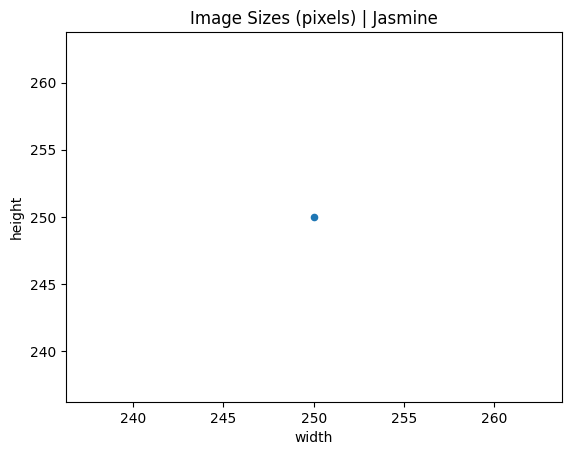

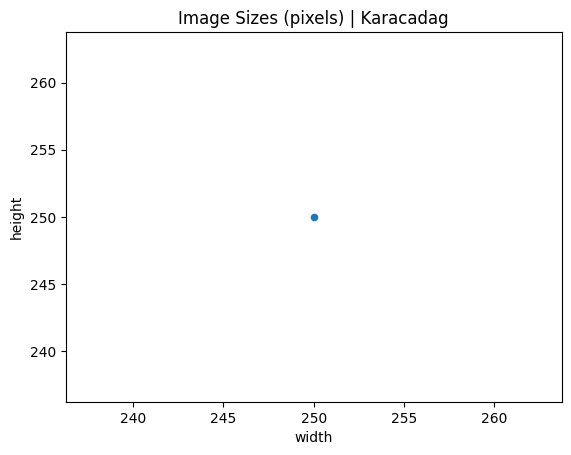

In [8]:
for n,d in directories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = db.from_sequence(filelist).map(get_dims)
    with ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        
        sizes.plot.scatter(x='width', y='height');
        plt.title('Image Sizes (pixels) | {}'.format(n))

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


## Displaying 20 random Grain images of the dataset with their labels

In [10]:
data = r"C:\Users\vilas\Rice_Image_Dataset"

In [11]:
image_dir = Path(data)

# Get filepaths and labels
filepaths =  list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [12]:
image_df

,Filepath,Label
0,C:\Users\vilas\Rice_Image_Dataset\Arborio\Arbo...,Arborio
1,C:\Users\vilas\Rice_Image_Dataset\Arborio\Arbo...,Arborio
2,C:\Users\vilas\Rice_Image_Dataset\Arborio\Arbo...,Arborio
3,C:\Users\vilas\Rice_Image_Dataset\Arborio\Arbo...,Arborio
4,C:\Users\vilas\Rice_Image_Dataset\Arborio\Arbo...,Arborio
...,...,...
74995,C:\Users\vilas\Rice_Image_Dataset\Karacadag\Ka...,Karacadag
74996,C:\Users\vilas\Rice_Image_Dataset\Karacadag\Ka...,Karacadag
74997,C:\Users\vilas\Rice_Image_Dataset\Karacadag\Ka...,Karacadag
74998,C:\Users\vilas\Rice_Image_Dataset\Karacadag\Ka...,Karacadag


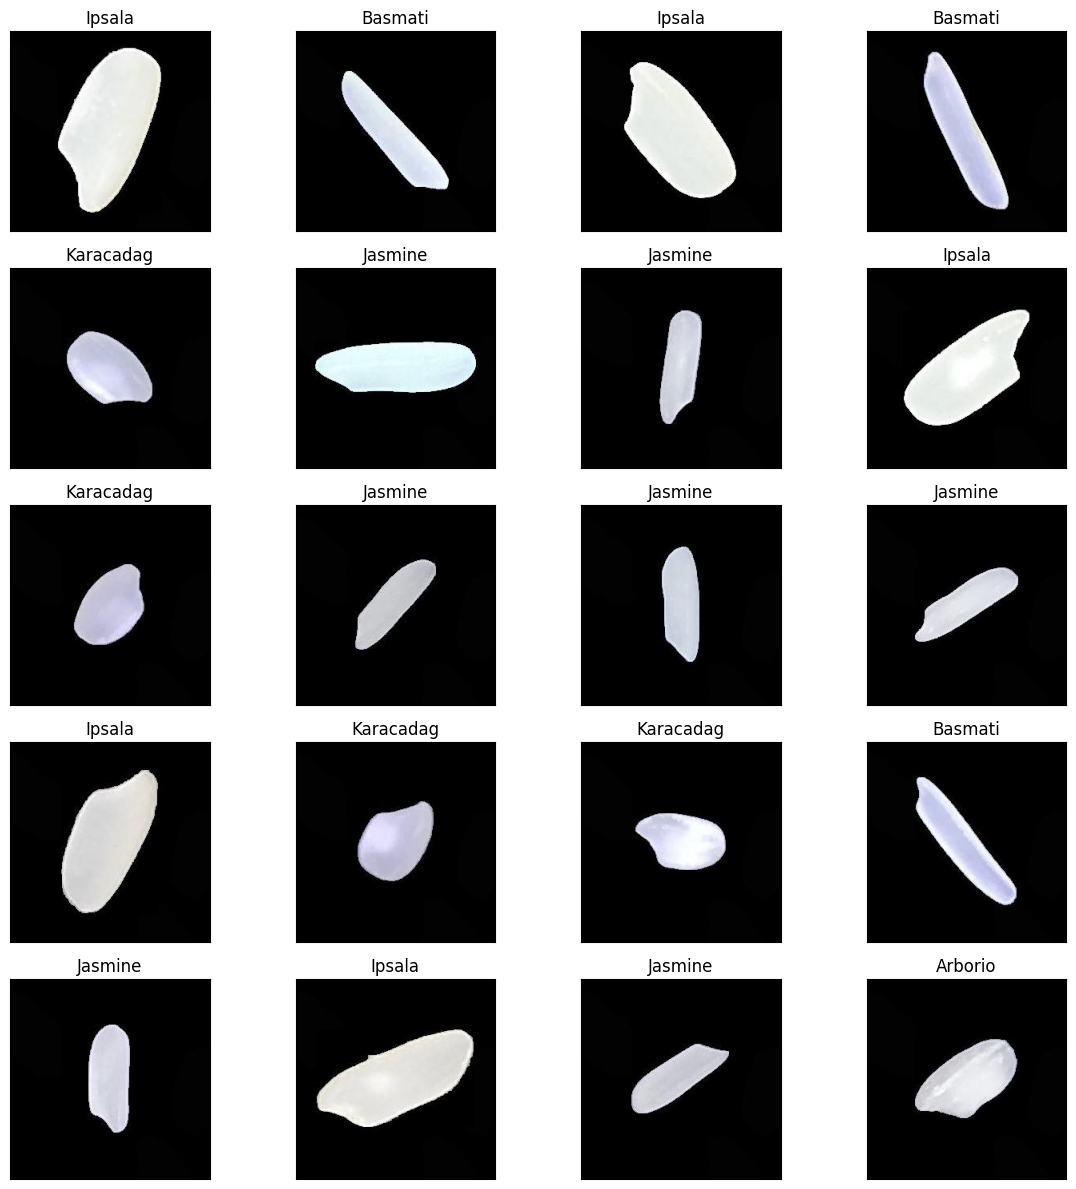

In [13]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 20)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## Displaying Grain Images seperately

### 1. Basmati Rice

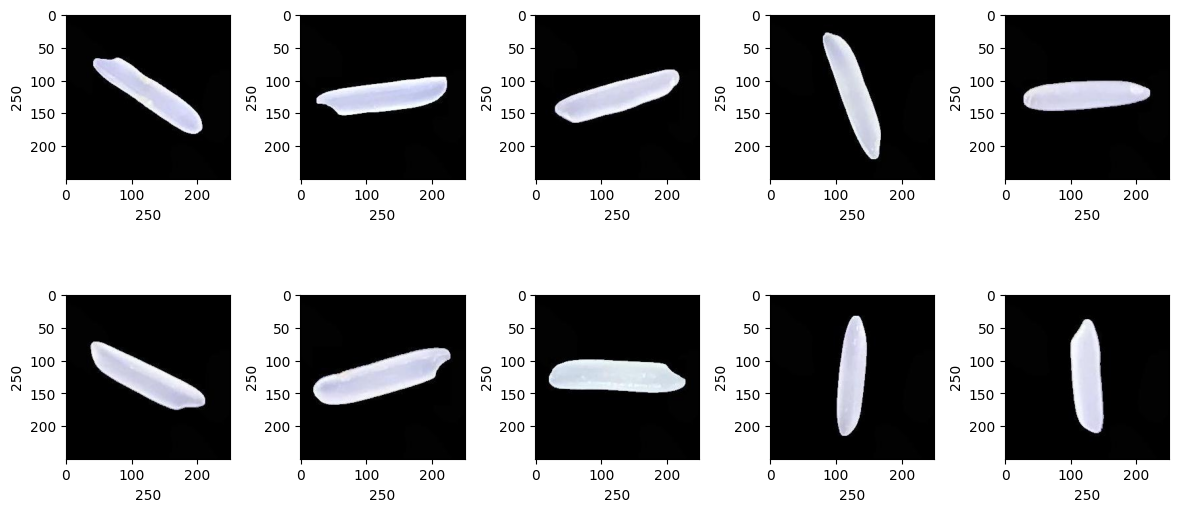

In [14]:
plt.figure(figsize=(12,6))
path = r"C:\Users\vilas\Rice_Image_Dataset\Basmati"
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

### 2. Arborio Rice

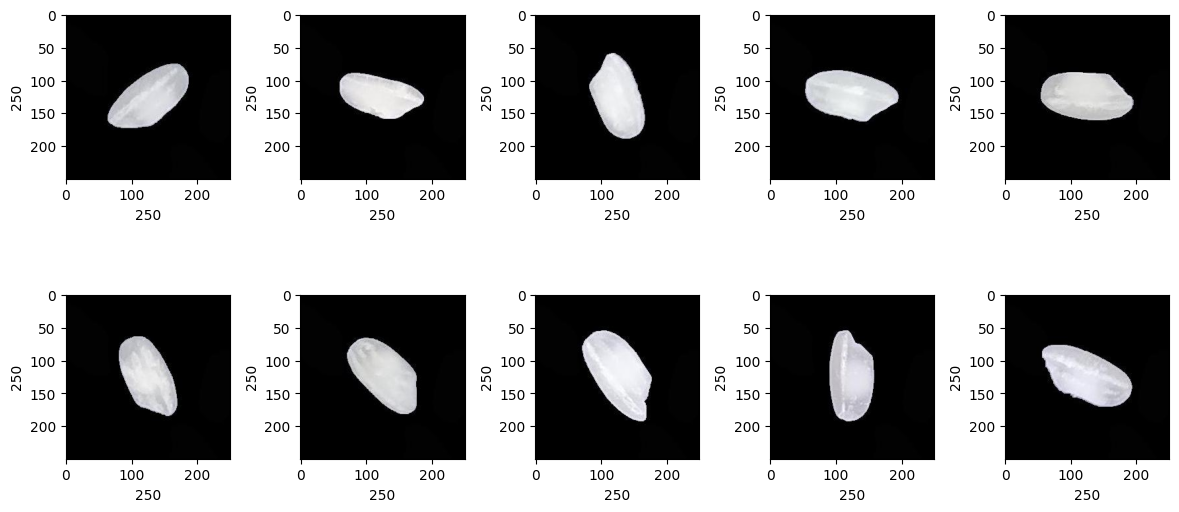

In [15]:
plt.figure(figsize=(12,6))
path = r"C:\Users\vilas\Rice_Image_Dataset\Arborio"
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

### 3. Ipsala Rice

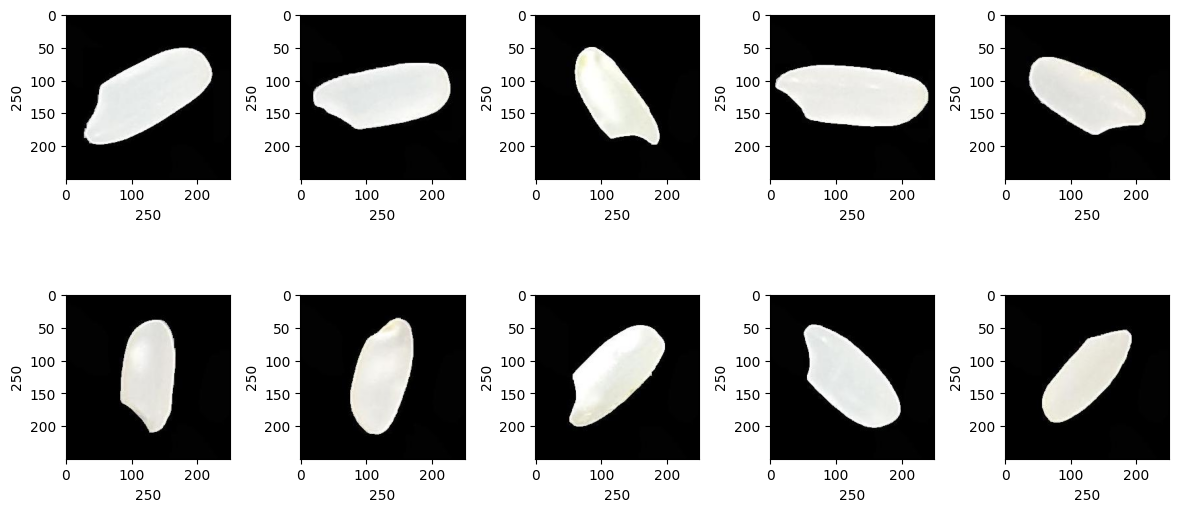

In [16]:
plt.figure(figsize=(12,6))
path = r"C:\Users\vilas\Rice_Image_Dataset\Ipsala"
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

### 4. Jasmine Rice

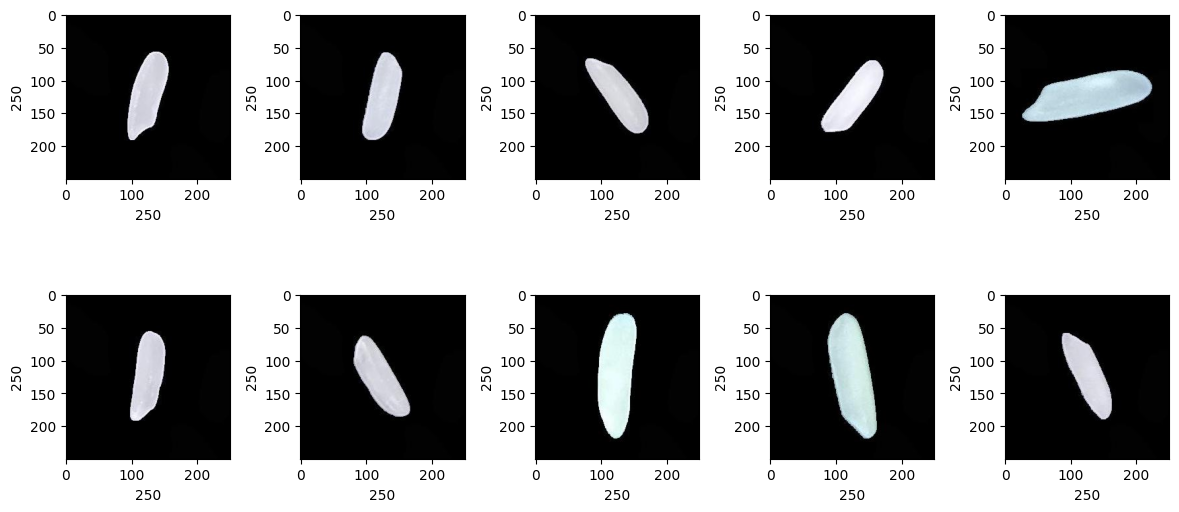

In [17]:
plt.figure(figsize=(12,6))
path = r"C:\Users\vilas\Rice_Image_Dataset\Jasmine"
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

### 5. Karacadag Rice

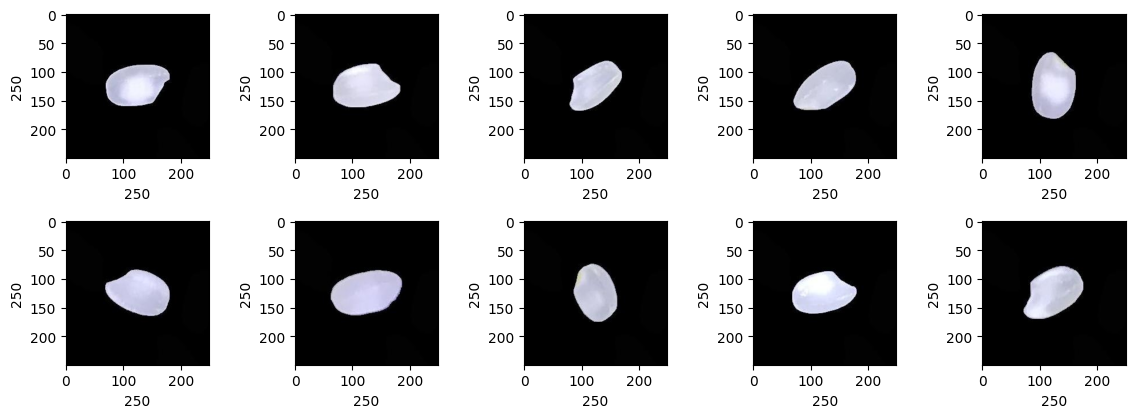

In [18]:
plt.figure(figsize=(12,8))
path = r"C:\Users\vilas\Rice_Image_Dataset\Karacadag"
for i in range(1,11):
    plt.subplot(4,5,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

## Data Preprocessing

Now we will observe some of the iamges that are their in our dataset. We will plot 12 images here using the matplotlib library.|

In [19]:
#Converting Images to array 
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (250,250))  
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

After visualizing the images let us move forward and create a function which will convert the images into a numpy array. It is required because we will normalize our dataset after this.

In [ ]:
dir = r"C:\Users\vilas\Rice_Image_Dataset"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
binary_labels = [0,1,2,3,4]
temp = -1

# Reading and converting image to numpy array
for directory in root_dir:
    plant_image_list = listdir(f"{dir}/{directory}")
    temp += 1
    for files in plant_image_list:
        image_path = f"{dir}/{directory}/{files}"
        image_list.append(convert_image_to_array(image_path))
        label_list.append(binary_labels[temp])

Now we will convert all the images into numpy array.

In [ ]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()